# Pemodelan dan Pembelajaran Sistem Petri Net Berwaktu Menggunakan Jaringan Syaraf Max-Plus

**Implementasi dari Paper: Learnable Petri Net Neural Network Using Max-Plus Algebra**

oleh: *Mohammed Sharafath Abdul Hameed, Sofiene Lassoued, Andreas Schwung*

### **1. Pendahuluan**

Perkembangan sistem produksi modern, transportasi otomatis, dan berbagai proses industri semakin menuntut adanya metode pemodelan yang mampu merepresentasikan dinamika waktu secara akurat. Salah satu pendekatan yang banyak digunakan untuk memodelkan perilaku sistem diskrit berwaktu adalah Petri Net, khususnya Timed Petri Net atau Timed Event Graph (TEG). Model ini memformalkan hubungan kausal dan keterlambatan (delay) antar kejadian sehingga memungkinkan analisis performa, penjadwalan, hingga verifikasi perilaku sistem. Namun, meskipun TEG memiliki struktur matematis yang kuat, penentuan parameter waktunya—yang direpresentasikan dalam bentuk matriks aljabar max-plus—seringkali mengandalkan pengetahuan pakar atau data hasil pengukuran manual. Proses ini rentan terhadap kesalahan dan sulit diterapkan ketika sistem memiliki kompleksitas tinggi.

Di sisi lain, jaringan syaraf tiruan (neural network) telah menjadi salah satu pendekatan paling efektif dalam mempelajari pola dan struktur tersembunyi dari data. Namun, sebagian besar jaringan syaraf klasik dirancang di dalam aljabar konvensional (penjumlahan–perkalian biasa), sehingga tidak selaras dengan operasi dasar yang digunakan dalam sistem TEG yang bekerja pada aljabar max-plus—di mana operasi utama adalah maksimum dan penjumlahan. Untuk menjembatani kesenjangan ini, beberapa penelitian terkini telah memperkenalkan konsep jaringan syaraf max-plus, yaitu arsitektur neural network yang mengganti operasi linear konvensional dengan operasi max-plus sehingga bersifat kompatibel secara matematis dengan TEG.

Makalah ini membahas pendekatan **pembelajaran sistem Petri Net berwaktu menggunakan jaringan syaraf max-plus**, suatu metode yang memungkinkan parameter sistem, khususnya matriks $A$ dan $B$ pada model:

$$
x(k+1) = A \otimes x(k) \oplus B \otimes u(k).
$$

Pendekatan ini memanfaatkan kesetaraan struktural antara satu langkah evolusi TEG dengan satu lapisan *maxout neural network* dalam aljabar max-plus. Dengan demikian, dinamika TEG dapat dipandang sebagai sebuah *recurrent max-plus neural network* yang parameternya dapat dioptimalkan melalui algoritma pembelajaran.

Pendekatan ini menawarkan beberapa keuntungan utama: 
- menghilangkan ketergantungan pada identifikasi parameter manual
- memungkinkan sistem menyesuaikan diri berdasarkan data operasional
- menyediakan kerangka matematis yang konsisten untuk integrasi Petri Net dengan teknik pembelajaran modern. 

Hasil akhirnya adalah model Petri Net berwaktu yang tidak hanya representatif terhadap logika proses, tetapi juga mampu menangkap karakteristik temporal sistem secara adaptif dan terukur.

Makalah ini akan membahas dasar teoritis Petri Net dan aljabar max-plus, konsep jaringan syaraf max-plus, proses pemetaan TEG ke dalam struktur neural network, serta metode pembelajaran parameter melalui data. Selain itu, contoh penerapan dan hasil eksperimen disertakan untuk menunjukkan efektivitas pendekatan yang diusulkan.


### **2. Landasan Teori**
Pada bagian ini akan dijelaskan konsep dasar yang digunakan dalam implementasi ini termasuk aljabar max-plus, timed event graph, dan neural network berbasis aljabar max-plus.

#### **2.1 Aljabar Max-Plus**
Aljabar max-plus adalah struktur aljabar yang menggunakan operasi maksimum dan penjumlahan sebagai operasi dasarnya. Merupakan bagian dari aljabar tropikal yang memiliki aplikasi luas dalam optimasi, teori kontrol, dan analisis sistem diskrit.

**Definisi 2.1.1 (Semiring Max-Plus)** 

Diberikan
$
\mathbb{R}_{\max} \overset{\text{def}}{=} \mathbb{R} \cup \{\varepsilon\},
$ dengan $\varepsilon \overset{\text{def}}{=} -\infty$.
Untuk setiap $x,y \in \mathbb{R}_{\max}$ didefinisikan operasi:
\begin{align*}
x \oplus y &\overset{\text{def}}{=} \max\{x,y\},\\
x \otimes y &\overset{\text{def}}{=} x + y.
\end{align*}
Dengan $\varepsilon$ sebagai elemen identitas untuk $\oplus$ dan $e=0$ sebagai elemen identitas untuk $\otimes$.

**Definisi 2.1.2 (Operasi matriks)**

Untuk setiap matriks $A,B \in \mathbb{R}^{m\times p}_{\max}$,
$$
[A \oplus B]_{i,j} \;=\; \max\{a_{i,j},\, b_{i,j}\}.
$$
dan untuk setiap $A \in \mathbb{R}^{m\times p}_{\max}$ dan $B \in \mathbb{R}^{p\times n}_{\max}$,
$$
[A \otimes B]_{i,j} \;=\; \max_{k}\,\{\, a_{i,k} + b_{k,j} \,\}.
$$

**Definisi 2.1.3 (Pangkat max‑plus)**

Untuk $A \in \mathbb{R}^{n\times n}_{\max}$ dan $k \in \mathbb{N}$,
$$
A^{\otimes k} \;=\; \underbrace{A \otimes A \otimes \cdots \otimes A}_{k \text{ kali}}.
$$

**Definisi 2.1.4 (Sistem Linier Max-Plus)**
Untuk sistem linier max-plus, keadaan sistem pada waktu $k$ diberikan oleh:
$$
x(k) = A \otimes x(k-1) \oplus B \otimes u(k),
$$
di mana $x(k)$ adalah vektor keadaan, $u(k)$ adalah vektor input, $A$ adalah matriks keadaan, dan $B$ adalah matriks input.

---


### **2.2 Petri Net**
Petri Net (PN) adalah model matematika yang digunakan untuk memodelkan sistem diskrit yang bersifat concurrent, asynchronous, distributed, parallel, nondeterministic, dan stochastic. Petri Net terdiri dari places, transitions, dan arcs yang menghubungkan keduanya.

**Definisi 2.2.1 (Petri Net)**
Sebuah Petri Net didefinisikan sebagai 5-tuple:

$$
\mathcal{N} = (P, T, A, W, M_0)
$$

dengan:

* $P = \{p_1,\dots,p_m\}$ : himpunan places
* $T = \{t_1,\dots,t_n\}$ : himpunan transitions
* $A \subseteq (P \times T) \cup (T \times P)$: himpunan arcs terarah
* $W : A \to \mathbb{N}_{>0}$: bobot arc
* $M_0 : P \to \mathbb{N}$: marking awal (jumlah token di tiap place)


**Definisi 2.2.2 (Pre dan Post set)**
Untuk setiap transition $t \in T$, pre-set dan post-set didefinisikan sebagai:
* Pre-set: ${}^\bullet t = \{ p \in P \mid (p,t) \in A \}$
* Post-set: $t^\bullet = \{ p \in P \mid (t,p) \in A \}$


**Definisi 2.2.3 (Enabled transition)**
Transition $t$ **enabled** pada marking $M$ jika dan hanya jika:

$$
\forall p \in P,\quad M(p) \ge {}^\bullet t(p)
$$

**Definisi 2.2.4 (Firing transition)**

Jika $t$ enabled pada marking $M$, maka firing $t$ menghasilkan marking baru:

$$
M' = M - {}^\bullet t + t^\bullet
$$

dengan:

$$
M'(p) = M(p) - {}^\bullet t(p) + t^\bullet(p)
$$
---

### **2.3 Coloured Petri Net (CPN)**

CPN adalah generalisasi dari Petri Net dengan tipe data (colour sets) dan fungsi ekspresi. Alasan penggunaan CPN adalah untuk memodelkan sistem yang kompleks dengan berbagai jenis token dan aturan transisi yang lebih rumit.

**Definisi 2.3.1 (Coloured Petri Net)**

Sebuah CPN didefinisikan sebagai tuple:

$$
\mathcal{CPN} = (P, T, A, \Sigma, C, G, E, M_0)
$$

dengan:

* $P$: places
* $T$: transitions
* $A \subseteq (P \times T) \cup (T \times P)$: arcs
* $\Sigma$: himpunan colour sets (tipe data)
* $C: P \cup T \to \Sigma$: colour-type function (tipe token/variabel)
* $G : T \to \text{BoolExpr}(\Sigma)$: guard function
* $E : A \to \text{Expr}(\Sigma)$: arc inscription (ekspresi pembentukan token)
* $M_0 : P \to \mathcal{B}(C(p))$: initial marking berupa multiset dari colours


**Definisi 2.3.2 (Binding elements)**

Untuk transition $t$, sebuah **binding** $b$ adalah pemetaan:

$$
b : \text{Var}(t) \to \Sigma
$$

yang memenuhi guard:

$$
G(t)[b] = \texttt{true}.
$$

**Definisi 2.3.3 (Enabledness CPN version)**

Transition $t$ *enabled* di marking $M$ dengan binding $b$ jika:

Untuk setiap arc $((p,t))$:

$$
E(p,t)[b] \subseteq M(p)
$$


**Definisi 2.4.1 (Firing rule CPN version)**

Jika transition $t$ enabled dengan binding $b$, firing memberi marking baru:

$$
M' = M - \bigcup_{p\in P} E(p,t)[b] + \bigcup_{p\in P} E(t,p)[b].
$$
---



### **2.4 Unfolding Coloured Petri Net**
Unfolding adalah proses mengubah CPN menjadi PN biasa dengan mengeliminasi warna (colour) dan binding melalui ekspansi eksplisit. Alasan penggunaan unfolding adalah untuk menyederhanakan analisis dan simulasi sistem yang dimodelkan oleh CPN karena pada dasarnya alat atau algoritma analisis sering kali dirancang untuk PN biasa.


**Definisi 2.4.1 (Unfolding CPN)**
Unfolding adalah fungsi matematis:

$$
U : \mathcal{CPN} \longrightarrow \mathcal{PN}
$$

yang menghasilkan **Petri Net tanpa warna**, yaitu:

$$
\mathcal{PN} = (P', T', A', W', M_0')
$$

Tujuan utama unfolding adalah membuat **representasi eksplisit** dari setiap kemungkinan nilai warna (colour) dan setiap binding. Unfolding secara formal dilakukan dengan **produk kartesian** dari komponen struktur dengan domain warna.

**Definisi 2.4.2 (Unfolded Places)**
Jika sebuah place $p \in P$ memiliki colour domain $C(p) = \{c_1, \dots, c_k\}$, maka:

$$
P' = \bigcup_{p\in P} \{ p^{c} \mid c \in C(p) \}
$$

Artinya setiap place CPN → menghasilkan satu **unfolded place** untuk tiap warna.


**Definisi 2.4.3 (Unfolded Transitions)**

Untuk transition $t \in T$, definisikan himpunan **binding elements valid**:

$$
B(t) = \{ b \mid b : \text{Var}(t)\to \Sigma, \; G(t)[b] = \texttt{true} \}
$$

Maka unfolded transitions adalah:
$$
T' = \bigcup_{t\in T} \{ t^{b} \mid b \in B(t) \}
$$

Artinya setiap transition CPN → menghasilkan **satu transition** untuk setiap binding warna yang valid.

**Definisi 2.4.4 (Unfolded Arcs)**

Untuk arc $(p,t) \in A$, warna $c \in C(p)$, dan binding $b \in B(t)$:

Jika arc inscription menghasilkan multiset:

$$
E(p,t)[b] = m_c \quad (\text{token warna } c)
$$

maka:

$$
A' \ni \left( p^{c}, t^{b} \right) \quad \text{dengan bobot } W'(p^c, t^b) = m_c
$$

Untuk arc dari (t) ke (p):

$$
A' \ni \left( t^{b}, p^c \right) \quad \text{jika } c \in E(t,p)[b]
$$


**Definisi 2.4.5 (Unfolded Marking)**

Jika marking awal:

$$
M_0(p) = \sum_{c\in C(p)} m_{p,c} \cdot c
$$

Maka unfolded marking:

$$
M_0'(p^c) = m_{p,c}
$$
---


### **2.5 Timed Event Graph (TEG)**

TEG adalah subclass dari Petri Net yang sangat terstruktur sehingga bisa direduksi menjadi sistem linear max-plus.

**Definisi 2.5.1 (Timed Event Graph)**
TEG adalah Petri Net:

$$
\mathcal{G} = (P,T,A,W,M_0,d)
$$

dengan property khusus:

1. **Setiap place memiliki persis 1 token**:
   $$
   M(p) = 1 ,\quad \forall p \in P.
   $$

2. **Semua arc memiliki bobot 1**
   (atau dapat direduksi ke 1 melalui normalisasi).

3. **Setiap transition memiliki delay waktu**
   $$
   d : T \to \mathbb{R}_{\ge 0}.
   $$
4. **Setiap place memiliki satu input dan satu output**
   (graph berstruktur event–event).

Karena ini, marking tidak berubah (token berputar), sehingga **dinamika hanya pada waktu firing**.


Definisikan:

* $x_i(k)$: waktu firing ke–$k$ dari transition $t_i$.
* Setiap arc $t_j \to t_i$ memiliki bobot waktu $w_{ij} \in \mathbb{R}\cup\{-\infty\}$ (gabungan delay dan constraint).

Transition $t_i$ hanya dapat fire setelah semua predecessor selesai **dan** delay dipenuhi.

Secara matematis:

$$
x_i(k+1) = \bigoplus_{j=1}^{n} \left(w_{ij} \otimes x_j(k)\right)
= \max_j \left( w_{ij} + x_j(k) \right).
$$

Jika ada input eksternal $u(k)$:

$$
x_i(k+1)
= \max\left( \max_j (A_{ij} + x_j(k)), \max_b (B_{ib} + u_b(k)) \right).
$$

Dengan notasi max-plus:

$$
x(k+1) = A \otimes x(k) \oplus B \otimes u(k)
$$

Di mana:

* $A \in (\mathbb{R}\cup\{-\infty\})^{n \times n}$
* $B \in (\mathbb{R}\cup\{-\infty\})^{n \times m}$


Karena struktur event graph sangat teratur:

$$
x(k+1) = A \otimes x(k)
$$

adalah sistem linear dalam **aljabar max-plus**, sehingga:

* throughput = nilai eigen max-plus
* jalur kritis = eigenvector max-plus
* schedule optimal = solusi kontrol linier max-plus
* identifikasi A, B dari data → feasible (yang Anda lakukan!)
---


### **2.6 Neural Network**

Neural network merupakan *universal approximator* yang mampu merepresentasikan hubungan non-linear yang kompleks antara input dan output. Arsitektur yang paling umum adalah **Multi-Layer Perceptron (MLP)**, yang secara matematis didefinisikan sebagai

$$
y_j = f\left(b_j + \sum_{i=1}^N w_{ij} x_i \right), \qquad j = 1,\dots,M,
$$

dengan:

* (x_i) = komponen input,
* (w_{ij}) = bobot neuron,
* (b_j) = bias neuron,
* (f(\cdot)) = fungsi aktivasi (ReLU, sigmoid, dsb.).

sebuah model yang diperoleh dari Petri Net—dapat direpresentasikan secara *ekivalen* oleh sebuah **neural network khusus**, yaitu **maxout neural network** dalam **aljabar tropical (max-plus)**. Hasil akhirnya adalah bahwa dinamika waktu pada TEG:

$$
x(k+1) = A \otimes x(k) \oplus B \otimes u(k)
$$

dengan:

* $x(k)$ = vektor waktu firing event ke-(k),
* $u(k)$ = input eksternal,
* $A$, $B$ = matriks delay dari struktur Petri Net.

Jika kita mengganti:

* matriks bias $S$ pada maxout dengan matriks $A$ atau $B$,
* vektor input $v$ dengan $x(k)$ atau $u(k)$,

maka setiap bagian dari TEG dapat direpresentasikan oleh satu **maxout layer**, karena:

$$
A \otimes x(k) = \max_j (A_{ij} + x_j(k)),
$$

$$
B \otimes u(k) = \max_j (B_{ij} + u_j(k)).
$$

Kedua komponen tersebut selanjutnya digabungkan oleh sebuah **max-pooling** element-wise:

$$
x_i(k+1) =
\bigoplus_{j}
\left(
A_{ij} \otimes x_j(k),;
B_{ij} \otimes u_j(k),;
\bar{b}_i(k)
\right),
$$

Karena TEG dapat direpresentasikan sebagai **recurrent maxout neural network**, maka bobot maxout tersebut dapat diperlakukan sebagai parameter neural network biasa.
Artinya:

* $A$ dan $B$ dapat diperlakukan sebagai *weight matrix*,
* dan dapat dipelajari menggunakan *gradient descent*, *Adam*, momentum, atau teknik optimisasi lain.

Dataset yang digunakan berupa pasangan:

$$
(x(k), u(k), x(k+1)),
$$

sehingga proses training bertujuan meminimalkan kesalahan prediksi:

$$
\mathcal{L} = |A \otimes x(k) \oplus B \otimes u(k) - x(k+1)|.
$$

Dengan demikian:

> **Learning TEG = Learning RNN max-plus = Learning a maxout network**.

Konversi ini menjadikan TEG dapat dianalisis dan dioptimalkan menggunakan perangkat neural network modern, dan inilah dasar pendekatan pembelajaran matriks $A$ dan $B$.


### **3. Hasil dan Pembahasan**
Berdasarkan implementasi dari paper tersebut, berikut adalah hasil pemodelan dan pembelajaran sistem Petri Net berwaktu menggunakan jaringan syaraf max-plus.

#### **3.1 Robot Manufacturing Cell Model**
<img src="robot_model.png" alt="Robot Manufacturing Cell" width="1000"/>

Berdasarkan paper, kita akan memodelkan robot manufacturing cell dengan:
- **2 Workpiece Types**: $WP_1$ dan $WP_2$
- **3 Processing Stations**: $S_1$, $S_2$, $S_3$
- **2 Input Stations**: $IB_1$, $IB_2$
- **1 Output Station**: $OB$

**Routing:**
- $WP_1$: $IB_1 \to S_1 \to S_2 \to S_3 \to OB$
- $WP_2$: $IB_2 \to S_2 \to S_3 \to S_1 \to OB$

Penjadwalan optimal dapat diformulasikan sebagai masalah optimisasi berikut:
\begin{align}
S_{i,j+1} &\ge S_{ij} + p_{ij}, \quad &&\forall\, i,j, \\
S_{ij} &\ge S_{kl} + p_{kl} \;\; \text{or} \;\; 
S_{kl} \ge S_{ij} + p_{ij}, 
\quad &&\forall\, (i,j)\neq(k,l)\ \text{with}\ M(O_{ij}) = M(O_{kl}), \\
C_{\max} &= \max_{i,j}\left( S_{ij} + p_{ij} \right) \;\to\; \min.
\end{align}


Matriks $T$ menyatakan waktu perpindahan robot (dalam detik) antar stasiun kerja
$S_1$, $S_2$, dan $S_3$. Setiap elemen $T_{ij}$ menunjukkan waktu yang dibutuhkan
robot untuk berpindah dari stasiun $S_i$ ke stasiun $S_j$. Nilai pada diagonal
berisi nol karena tidak diperlukan perpindahan jika robot tetap berada pada
stasiun yang sama.

$$
T =
\begin{array}{c|ccc}
   & S_1 & S_2 & S_3 \\ \hline
S_1 & 0 & 2 & 4 \\
S_2 & 2 & 0 & 3 \\
S_3 & 4 & 3 & 0
\end{array}
$$

Processing times (dalam detik) untuk setiap *workpiece* pada masing-masing stasiun ditunjukkan pada tabel berikut. Tanda hubung (–) menyatakan bahwa stasiun tersebut tidak digunakan oleh *workpiece* terkait.

| Station              | WP1 | WP2 |
| -------------------- | --- | --- |
| Input station (IB₁)  | 0   | –   |
| Input station (IB₂)  | –   | 0   |
| Working station (S₁) | 10  | 30  |
| Working station (S₂) | 20  | 10  |
| Working station (S₃) | 30  | 20  |
| Output station (OB)  | 0   | 0   |


Berikut adalah representasi Petri Net dari robot

<img src="robot_petri_net.png" alt="Robot Manufacturing Cell Petri Net" width="1000"/>



In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [3]:
# Processing times dari paper (Table 1)
processing_times = {
    'WP1': {'IB1': 0, 'S1': 12, 'S2': 20, 'S3': 10, 'OB': 0},
    'WP2': {'IB2': 0, 'S1': 3, 'S2': 10, 'S3': 20, 'OB': 0}
}

stations = ['S1', 'S2', 'S3']
T = np.array([
    [0, 2, 4],  # dari S1 ke [S1, S2, S3]
    [2, 0, 3],  # dari S2 ke [S1, S2, S3]
    [4, 3, 0]   # dari S3 ke [S1, S2, S3]
], dtype=float)

print("=== Robot Manufacturing Cell Configuration ===")
print("\nProcessing Times (detik):")
# Dynamic print of routes using processing_times
wp1_order = ['IB1', 'S1', 'S2', 'S3', 'OB']
wp2_order = ['IB2', 'S2', 'S3', 'S1', 'OB']

def fmt_time(t):
    try:
        ft = float(t)
        return str(int(ft)) if ft.is_integer() else f"{ft:.2f}"
    except Exception:
        return str(t)

for wp, order in [('WP1', wp1_order), ('WP2', wp2_order)]:
    parts = []
    for loc in order:
        t = processing_times.get(wp, {}).get(loc, None)
        parts.append(f"{loc}({fmt_time(t)})" if t is not None else f"{loc}(?)")
    print(f"{wp}: " + " → ".join(parts))
    
print("\nTransport Time Matrix T:")
print(T)

=== Robot Manufacturing Cell Configuration ===

Processing Times (detik):
WP1: IB1(0) → S1(12) → S2(20) → S3(10) → OB(0)
WP2: IB2(0) → S2(10) → S3(20) → S1(3) → OB(0)

Transport Time Matrix T:
[[0. 2. 4.]
 [2. 0. 3.]
 [4. 3. 0.]]


#### **3.2 Timed Event Graph (TEG) Model**

Persamaan dater untuk TEG dalam max-plus algebra:

$$x^d(k+1) = A \otimes x^d(k) \oplus B \otimes u^d(k)$$

Di mana:
- $x^d(k)$: state vector (firing times)
- $u^d(k)$: input vector
- $A$: state matrix
- $B$: input matrix

In [4]:
epsilon = -np.inf
e = 0

n = len(stations)
A = np.full((n, n), epsilon)

for i, si in enumerate(stations):
    for j, sj in enumerate(stations):

        # Waktu proses di station j
        p_j = processing_times['WP1'][sj]   # WP1 dan WP2 sama durasi, urutan saja beda

        # Waktu transport si -> sj
        t_ij = T[i, j]

        # Total delay: proses di j + transport dari i ke j
        total = p_j + t_ij

        # Jika tidak ada dependency, tetap boleh; nanti beberapa diset -∞
        A[j, i] = total


B = np.full((n, 2), epsilon)  # dua input: IB1 dan IB2

# IB1 → S1
B[stations.index('S1'), 0] = processing_times['WP1']['S1']

# IB2 → S2
B[stations.index('S2'), 1] = processing_times['WP2']['S2']

A_ref = A.copy()
B_ref = B.copy()

print("A matrix (robot realistic):")
print(A)

print("\nB matrix (robot realistic):")
print(B)

A matrix (robot realistic):
[[12. 14. 16.]
 [22. 20. 23.]
 [14. 13. 10.]]

B matrix (robot realistic):
[[ 12. -inf]
 [-inf  10.]
 [-inf -inf]]


### **3.3 Tropical Neural Network**

Jaringan neural dalam max-plus algebra dengan arsitektur two-layer maxout network:

$$x_i(k+1) = \bigoplus_{i=0}^{|Q|} (A_{ij} \otimes x_j \oplus B_{ij} \otimes u_i \otimes v(k))$$

Di mana:
- Hard-max unit: $h(x) = \max_{j \in [0,|Q|]} z_{ij}$
- $z_{ij} = s_{ij} \otimes v_j$ untuk maxout network

In [ ]:
class TropicalNeuralNetwork:
    
    def __init__(self, n_states, n_inputs, init_scale=0.5, random_state=None,
                 min_weight=-80.0, idle_decay=0.0, active_threshold=1e-4):
        self.n_states = n_states
        self.n_inputs = n_inputs
        
        rng = np.random.default_rng(random_state)
        self.A = rng.uniform(-init_scale, init_scale, (n_states, n_states))
        self.B = rng.uniform(-init_scale, init_scale, (n_states, n_inputs))
        
        self.a_paths = [None] * n_states
        self.b_paths = [None] * n_states
        
        self.velocity_A = np.zeros_like(self.A)
        self.velocity_B = np.zeros_like(self.B)
        
        self.min_weight = min_weight
        self.idle_decay = idle_decay
        self.active_threshold = active_threshold
        
    def forward(self, x, u):
        
        self.a_paths = [None] * self.n_states
        self.b_paths = [None] * self.n_states
        
        y_a = np.full(self.n_states, -np.inf)
        for i in range(self.n_states):
            for j in range(self.n_states):
                val = self.A[i, j] + x[j]
                if val > y_a[i]:
                    y_a[i] = val
                    self.a_paths[i] = (i, j)
        
        y_b = np.full(self.n_states, -np.inf)
        for i in range(self.n_states):
            for j in range(self.n_inputs):
                val = self.B[i, j] + u[j]
                if val > y_b[i]:
                    y_b[i] = val
                    self.b_paths[i] = (i, j)
        
        y = np.zeros(self.n_states)
        for i in range(self.n_states):
            if y_a[i] > y_b[i]:
                y[i] = y_a[i]
                self.b_paths[i] = None
            else:
                y[i] = y_b[i]
                self.a_paths[i] = None
        
        return y
    
    def compute_gradients(self, error):
        grad_A = np.zeros_like(self.A)
        grad_B = np.zeros_like(self.B)
        
        for i in range(len(error)):
            if self.a_paths[i] is not None:
                row, col = self.a_paths[i]
                grad_A[row, col] += error[i]
            if self.b_paths[i] is not None:
                row, col = self.b_paths[i]
                grad_B[row, col] += error[i]
        
        return grad_A, grad_B
    
    def apply_gradients(self, grad_A, grad_B, learning_rate=0.1, momentum=0.9,
                        clip_value=None, idle_decay=None, min_weight=None,
                        active_threshold=None):
        if clip_value is not None:
            grad_A = np.clip(grad_A, -clip_value, clip_value)
            grad_B = np.clip(grad_B, -clip_value, clip_value)
        
        self.velocity_A = momentum * self.velocity_A + learning_rate * grad_A
        self.velocity_B = momentum * self.velocity_B + learning_rate * grad_B
        
        self.A -= self.velocity_A
        self.B -= self.velocity_B
        
        decay = self.idle_decay if idle_decay is None else idle_decay
        min_w = self.min_weight if min_weight is None else min_weight
        threshold = self.active_threshold if active_threshold is None else active_threshold
        if decay > 0.0:
            active_A = np.abs(grad_A) > threshold
            inactive_A = ~active_A
            if np.any(inactive_A):
                self.A[inactive_A] = np.maximum(self.A[inactive_A] - decay, min_w)
            active_B = np.abs(grad_B) > threshold
            inactive_B = ~active_B
            if np.any(inactive_B):
                self.B[inactive_B] = np.maximum(self.B[inactive_B] - decay, min_w)
        
    def backward(self, error, learning_rate=0.1, momentum=0.9, clip_value=None,
                 idle_decay=None, min_weight=None, active_threshold=None):
        grad_A, grad_B = self.compute_gradients(error)
        self.apply_gradients(grad_A, grad_B, learning_rate=learning_rate, momentum=momentum,
                             clip_value=clip_value, idle_decay=idle_decay, min_weight=min_weight,
                             active_threshold=active_threshold)
        return grad_A, grad_B
    
    def get_parameters(self):
        return self.A.copy(), self.B.copy()

### **3.4 Dataset Generation**

Kita akan membuat synthetic dataset dengan:
- Random system matrices A dan B (frozen/reference)
- Generate trajectories: $(x(k), u(k), x(k+1))$
- Data ini akan digunakan untuk melatih TNN

In [6]:
dataset_size = 50000
n_states = A_ref.shape[0]
n_inputs = B_ref.shape[1]

rng_dataset = np.random.default_rng(0)
dataset = []
for _ in range(dataset_size):  # lebih banyak sampel untuk stabilitas learning
    x = rng_dataset.uniform(0.0, 10.0, size=n_states)
    if rng_dataset.random() < 0.3:
        mask = rng_dataset.random(n_states) < 0.5
        x[mask] = -50
    u = rng_dataset.uniform(0.0, 10.0, size=n_inputs)
    # A ⊗ x
    Ax = np.max(A_ref + x[None, :], axis=1)
    # B ⊗ u (broadcast kolom tunggal)
    Bu = np.max(B_ref + u[None, :], axis=1)
    # Ax ⊕ Bu (element-wise max)
    x_next = np.maximum(Ax, Bu)
    dataset.append((x, u, x_next))

print(f"Generated dataset size: {len(dataset)} samples")

Generated dataset size: 50000 samples


### **3.5 Training Algorithm (Supervised Learning)**

Implementasi **Algorithm 1** dari paper:
1. **Forward Pass**: Prediksi output berdasarkan input
2. **Loss Calculation**: L1 loss = $|x̂(k+1) - x(k+1)|$
3. **Backward Pass**: Update weights menggunakan gradient

In [7]:
def train_tnn(dataset, n_states, n_inputs,
              lr=0.02,
              epochs=20,
              momentum=0.9,
              lr_decay=0.97,
              lr_floor=1e-3,
              clip_value=5.0,
              init_scale=0.5,
              shuffle=True,
              batch_size=64,
              smoothing_ratio=0.05,
              ema_alpha=0.2,
              verbose_epochs=1,
              random_seed=42,
              idle_decay=0.0,
              min_weight=-80.0,
              inactive_threshold=1e-4,
              loss_focus='all',
              change_eps=1e-6):
    """Latih TropicalNeuralNetwork hanya dari dataset (x, u, x_next).
    Dilengkapi penstabil training agar konvergen tanpa A_ref/B_ref.

    dataset: iterable berisi tuple (x, u, x_next)
    loss_focus: 'all' untuk seluruh dimensi, 'changed' hanya dimensi yang berubah (x_next != x).
    change_eps: ambang perubahan untuk menentukan dimensi berubah."""
    print("=" * 60)
    print("📊 TRAINING TNN (UNSUPERVISED, NO A_ref/B_ref)")
    print("=" * 60)

    dataset = list(dataset)
    if len(dataset) == 0:
        raise ValueError("Dataset kosong, tidak ada sampel untuk training.")
    
    rng = np.random.default_rng(random_seed)
    tnn = TropicalNeuralNetwork(n_states, n_inputs, init_scale=init_scale,
                                 random_state=rng.integers(2**32 - 1),
                                 min_weight=min_weight, idle_decay=idle_decay,
                                 active_threshold=inactive_threshold)
    
    loss_hist = []
    epoch_losses = []
    lr_history = []
    ema_losses = []
    best_state = None
    best_epoch_loss = np.inf
    
    print(f"\n📊 Goal: Predict x_next from (x, u) only")
    print(f"   n_states = {n_states}, n_inputs = {n_inputs}")
    print(f"   Total samples: {len(dataset)}, Epochs: {epochs}")
    if idle_decay > 0.0:
        print(f"   Idle decay per step: {idle_decay}")
        print(f"   Minimum allowed weight: {min_weight}")
    print(f"   Inactive threshold: {inactive_threshold}\n")
    print(f"   Loss focus: {loss_focus} | change_eps={change_eps}\n")
    
    sample_indices = np.arange(len(dataset))
    for epoch in range(epochs):
        if shuffle:
            rng.shuffle(sample_indices)
        current_lr = max(lr_floor, lr * (lr_decay ** epoch))
        running_loss = 0.0
        
        batch_grad_A = np.zeros((n_states, n_states))
        batch_grad_B = np.zeros((n_states, n_inputs))
        batch_loss_sum = 0.0
        batch_count = 0
        steps_this_epoch = 0
        
        for pos, idx in enumerate(sample_indices):
            x, u, x_target = dataset[idx]
            u_used = u[:n_inputs]
            
            y_pred = tnn.forward(x, u_used)
            err_vec = y_pred - x_target
            
            if loss_focus == 'changed':
                changed_mask = np.abs(x_target - x) > change_eps
                if np.any(changed_mask):
                    sample_loss = float(np.mean(np.abs(err_vec[changed_mask])))
                    # Mask gradients to changed dims only
                    err_used = err_vec.copy()
                    err_used[~changed_mask] = 0.0
                else:
                    sample_loss = float(np.mean(np.abs(err_vec)))
                    err_used = err_vec
            else:
                sample_loss = float(np.mean(np.abs(err_vec)))
                err_used = err_vec
            
            running_loss += sample_loss
            batch_loss_sum += sample_loss
            batch_count += 1
            
            grad_A, grad_B = tnn.compute_gradients(err_used)
            batch_grad_A += grad_A
            batch_grad_B += grad_B
            
            is_last_sample = (pos == len(sample_indices) - 1)
            if batch_count == batch_size or is_last_sample:
                batch_grad_A /= batch_count
                batch_grad_B /= batch_count
                tnn.apply_gradients(batch_grad_A, batch_grad_B,
                                    learning_rate=current_lr, momentum=momentum,
                                    clip_value=clip_value,
                                    idle_decay=idle_decay,
                                    min_weight=min_weight,
                                    active_threshold=inactive_threshold)
                avg_batch_loss = batch_loss_sum / batch_count
                loss_hist.append(avg_batch_loss)
                if ema_losses:
                    ema_losses.append(ema_alpha * avg_batch_loss + (1 - ema_alpha) * ema_losses[-1])
                else:
                    ema_losses.append(avg_batch_loss)
                batch_grad_A.fill(0.0)
                batch_grad_B.fill(0.0)
                batch_loss_sum = 0.0
                batch_count = 0
                steps_this_epoch += 1
        
        epoch_loss = running_loss / len(dataset)
        epoch_losses.append(epoch_loss)
        lr_history.append(current_lr)
        
        if epoch_loss < best_epoch_loss:
            best_epoch_loss = epoch_loss
            best_state = (tnn.A.copy(), tnn.B.copy())
        
        if (epoch + 1) % max(1, verbose_epochs) == 0:
            print(f"   Epoch {epoch + 1:02d}/{epochs:02d} | lr={current_lr:.4f} | avg loss={epoch_loss:.4f}")
    
    if best_state is not None:
        tnn.A = best_state[0]
        tnn.B = best_state[1]
    
    print("\n✅ Training complete!")
    if loss_hist:
        initial_loss = loss_hist[0]
        final_step_loss = loss_hist[-1]
        final_epoch_loss = epoch_losses[-1]
        reduction = ((initial_loss - final_epoch_loss) / initial_loss) * 100 if initial_loss != 0 else 0.0
        print("\n📊 Loss Summary:")
        print(f"   First batch loss : {initial_loss:.3f}")
        print(f"   Last batch loss  : {final_step_loss:.3f}")
        print(f"   Final epoch avg  : {final_epoch_loss:.3f}")
        print(f"   Overall drop     : {reduction:.1f}%")
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(loss_hist, alpha=0.4, linewidth=1.2, color='#1f77b4', label='Batch Avg Loss')
    
    if ema_losses:
        ax.plot(ema_losses, color='#ff7f0e', linewidth=2.0, label=f'EMA (α={ema_alpha})')
    
    ax.set_xlabel('Optimizer Step', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean L1 Loss', fontsize=11, fontweight='bold')
    ax.set_title('Prediction Loss Convergence', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    history = {
        'loss_per_step': loss_hist,
        'loss_ema': ema_losses,
        'loss_per_epoch': epoch_losses,
        'lr_per_epoch': lr_history,
        'idle_decay': idle_decay,
        'min_weight': min_weight,
        'inactive_threshold': inactive_threshold,
        'loss_focus': loss_focus,
        'change_eps': change_eps
    }
    
    return tnn, history

📊 TRAINING TNN (UNSUPERVISED, NO A_ref/B_ref)

📊 Goal: Predict x_next from (x, u) only
   n_states = 3, n_inputs = 2
   Total samples: 50000, Epochs: 120
   Idle decay per step: 0.08
   Minimum allowed weight: -140.0
   Inactive threshold: 0.005

   Loss focus: all | change_eps=1e-06

   Epoch 06/120 | lr=0.0226 | avg loss=0.0630
   Epoch 06/120 | lr=0.0226 | avg loss=0.0630
   Epoch 12/120 | lr=0.0200 | avg loss=0.0613
   Epoch 12/120 | lr=0.0200 | avg loss=0.0613
   Epoch 18/120 | lr=0.0177 | avg loss=0.0628
   Epoch 18/120 | lr=0.0177 | avg loss=0.0628
   Epoch 24/120 | lr=0.0157 | avg loss=0.0614
   Epoch 24/120 | lr=0.0157 | avg loss=0.0614
   Epoch 30/120 | lr=0.0139 | avg loss=0.0632
   Epoch 30/120 | lr=0.0139 | avg loss=0.0632
   Epoch 36/120 | lr=0.0123 | avg loss=0.0625
   Epoch 36/120 | lr=0.0123 | avg loss=0.0625
   Epoch 42/120 | lr=0.0109 | avg loss=0.0641
   Epoch 42/120 | lr=0.0109 | avg loss=0.0641
   Epoch 48/120 | lr=0.0097 | avg loss=0.0621
   Epoch 48/120 | lr=0.0

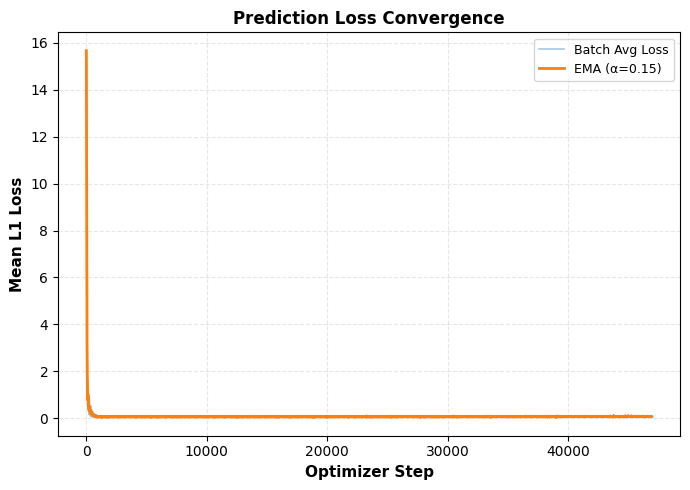


🔎 Learned matrix A:
[[11.864 13.897 15.967]
 [21.905 19.888 22.989]
 [13.955 12.957  9.909]]

🔎 Learned matrix B:
[[  11.935  -87.176]
 [ -84.334    9.699]
 [ -96.593 -101.641]]

A matrix (robot realistic):
[[12. 14. 16.]
 [22. 20. 23.]
 [14. 13. 10.]]

B matrix (robot realistic):
[[ 12. -inf]
 [-inf  10.]
 [-inf -inf]]


In [8]:
n_states = dataset[0][0].shape[0]
n_inputs = dataset[0][1].shape[0]

tnn_journal, hist_journal = train_tnn(
    dataset,
    n_states,
    n_inputs,
    lr=0.025,
    epochs=120,
    lr_decay=0.98,
    lr_floor=5e-4,
    momentum=0.85,
    clip_value=2.0,
    init_scale=0.25,
    batch_size=128,
    smoothing_ratio=0.0,
    ema_alpha=0.15,
    verbose_epochs=6,
    random_seed=1234,
    idle_decay=0.08,
    min_weight=-140.0,
    inactive_threshold=5e-3
)

learned_A, learned_B = tnn_journal.get_parameters()

np.set_printoptions(precision=3, suppress=True)
print("\n🔎 Learned matrix A:")
print(learned_A)
print("\n🔎 Learned matrix B:")
print(learned_B)
np.set_printoptions()

print("\nA matrix (robot realistic):")
print(A)
print("\nB matrix (robot realistic):")
print(B)

### **3.6 Real Dataset Training**

In [9]:
import json
import re
from pathlib import Path
import csv
import sys

DATA_PATH = Path("starjob130k.json")  # change if needed
OUT_EVENTLOG = Path("starjob_eventlog.csv")
OUT_PN_JSON = Path("generic_petri_net.json")

# Utility: parse a block like "J0:\nM10:122 M29:26 M15:178" into list of ops per job
op_line_re = re.compile(r'J\s*(\d+)\s*:\s*(.*)', re.IGNORECASE)
machine_token_re = re.compile(r'M\s*(\d+)\s*:\s*([0-9]+(?:\.[0-9]+)?)', re.IGNORECASE)

def parse_jobs_from_prompt(text):
    """
    Parse job-based prompt text and return jobs: list of list of dicts {'machine':int,'duration':float}
    Accepts strings like:
        "J0:\nM10:122 M29:26 M15:178\nJ1:\nM2:30 M5:20 ..."
    """
    if not isinstance(text, str):
        return None
    jobs = []
    # split into lines and group by lines that start with J
    lines = [ln.strip() for ln in re.split(r'[\r\n]+', text) if ln.strip()]
    current_job = None
    for ln in lines:
        m = op_line_re.match(ln)
        if m:
            # new job header possibly followed by machines on same line
            jidx, rest = int(m.group(1)), m.group(2).strip()
            # ensure list length
            while len(jobs) <= jidx:
                jobs.append([])
            if rest:
                # parse tokens in rest
                for mt in machine_token_re.finditer(rest):
                    mid = int(mt.group(1))
                    dur = float(mt.group(2))
                    jobs[jidx].append({'machine': mid, 'duration': dur})
            current_job = jidx
        else:
            # parse machine tokens in continuation lines
            if current_job is None:
                # maybe the line is like "M10:122 M29:26 ..." without job header; create a job
                jobs.append([])
                current_job = len(jobs) - 1
            for mt in machine_token_re.finditer(ln):
                mid = int(mt.group(1))
                dur = float(mt.group(2))
                jobs[current_job].append({'machine': mid, 'duration': dur})
    # Trim trailing empty jobs
    jobs = [j for j in jobs if j]
    return jobs if jobs else None

# Fallback parser for matrix+path format stored as a single string
matrix_pair_re = re.compile(r'(\d+)\s+(\d+)')  # simple numbers; used heuristically

def parse_instance_object(inst):
    """
    Given an instance dict, try to extract jobs list and metadata.
    Returns (num_jobs,num_machines,jobs) or None if cannot parse.
    """
    # try 'prompt_jobs_first' or 'input' fields
    for key in ('prompt_jobs_first','input','prompt','prompt_jobs','instance'):
        text = inst.get(key)
        if text:
            jobs = parse_jobs_from_prompt(text)
            if jobs:
                # infer num_jobs and num_machines
                num_jobs = inst.get('num_jobs') or len(jobs)
                max_machine = 0
                for ops in jobs:
                    for op in ops:
                        max_machine = max(max_machine, int(op['machine']))
                num_machines = inst.get('num_machines') or (max_machine + 1)
                return int(num_jobs), int(num_machines), jobs

    # try 'matrix' + 'path' combination (may be strings)
    if 'matrix' in inst and 'path' in inst:
        matrix_raw = inst['matrix']
        path_raw = inst['path']
        # If both are strings, attempt to parse numbers
        # Many Starjob variants put newline-separated rows; we try simple tokenization
        def tokenize_numbers(s):
            return [float(x) for x in re.findall(r'-?\d+\.?\d*', s)]
        # attempt to extract pairs: often matrix encodes durations after header "40 40\n..." etc.
        mat_nums = tokenize_numbers(matrix_raw) if isinstance(matrix_raw, str) else None
        path_nums = tokenize_numbers(path_raw) if isinstance(path_raw, str) else None
        # If we have both, attempt to reshape heuristically
        if mat_nums and path_nums:
            # Heuristic: first two numbers are num_jobs,num_machines
            if len(mat_nums) >= 2:
                nj, nm = int(mat_nums[0]), int(mat_nums[1])
                # remaining mat numbers represent durations row-major
                rem = mat_nums[2:]
                # path_nums likely contain machine labels in sequence; try to split by jobs using job lengths from path
                # Simpler fallback: parse path string by lines using parse_jobs_from_prompt on path_raw
                jobs_from_path = parse_jobs_from_prompt(path_raw)
                if jobs_from_path:
                    # Now try to map durations in rem into jobs order
                    # We cannot guarantee correct mapping; we will set durations to 1 if missing
                    jobs = []
                    idx = 0
                    for jops in jobs_from_path:
                        ops = []
                        for op in jops:
                            dur = rem[idx] if idx < len(rem) else 1.0
                            idx += 1
                            ops.append({'machine': int(op['machine']), 'duration': float(dur)})
                        jobs.append(ops)
                    num_jobs = nj
                    num_machines = nm
                    return int(num_jobs), int(num_machines), jobs

    # Last attempt: try to parse 'prompt_machines_first' which lists machines' sequences; convert to jobs by transposing
    if 'prompt_machines_first' in inst:
        pm = inst['prompt_machines_first']
        # parse lines like "M0:\nJ12:25 J5:37"
        lines = [ln.strip() for ln in re.split(r'[\r\n]+', pm) if ln.strip()]
        machine_ops = {}
        max_job = -1
        for ln in lines:
            m = re.match(r'M\s*(\d+)\s*:\s*(.*)', ln, re.IGNORECASE)
            if m:
                mid = int(m.group(1))
                rest = m.group(2)
                machine_ops[mid] = []
                for mt in re.finditer(r'J\s*(\d+)\s*:\s*([0-9]+(?:\.[0-9]+)?)', rest, re.IGNORECASE):
                    jid = int(mt.group(1))
                    dur = float(mt.group(2))
                    machine_ops[mid].append((jid, dur))
                    max_job = max(max_job, jid)
        if machine_ops:
            num_jobs = max_job + 1
            num_machines = max(machine_ops.keys()) + 1
            # build jobs by scanning job ids
            jobs = [[] for _ in range(num_jobs)]
            # For each machine, append operations to the corresponding jobs in the order seen
            for mid, ops in machine_ops.items():
                for jid, dur in ops:
                    jobs[jid].append({'machine': mid, 'duration': dur})
            return int(num_jobs), int(num_machines), jobs

    return None

# Main processing: iterate instances and write event log and collect machine/job counts
def process_starjob_json(path, out_csv, out_pn_json, max_instances=None):
    if not path.exists():
        print(f"File not found: {path}\nPlease place the Starjob JSON file at this location or update DATA_PATH variable.")
        return None

    # Try to stream parse if file begins with '[' (array)
    text_start = path.read_text()
    is_array = text_start.lstrip().startswith('[')
    instances_processed = 0
    global_max_jobs = 0
    global_max_machines = 0
    # We'll write CSV rows progressively
    with out_csv.open('w', newline='', encoding='utf-8') as csvf:
        writer = csv.writer(csvf)
        writer.writerow(['case_id', 'event_index', 'activity', 'resource', 'duration'])

        if is_array:
            # load using incremental parsing: use json.load but process elements one by one if memory allows
            # For large files, you may want to replace this with a streaming JSON parser.
            with path.open('r', encoding='utf-8') as f:
                data = json.load(f)
            for idx, inst in enumerate(data):
                if max_instances and instances_processed >= max_instances:
                    break
                parsed = parse_instance_object(inst)
                if parsed is None:
                    continue
                num_jobs, num_machines, jobs = parsed
                global_max_jobs = max(global_max_jobs, num_jobs)
                global_max_machines = max(global_max_machines, num_machines)
                # Create a trace: sequence of operations in a reasonable order.
                # We'll produce a trace by interleaving job orders: for each job append its ops in job order.
                case_id = f"inst_{idx}"
                event_index = 0
                for j_idx, ops in enumerate(jobs):
                    for op_idx, op in enumerate(ops):
                        act = f"J{j_idx}_O{op_idx}"
                        res = int(op['machine'])
                        dur = float(op['duration'])
                        writer.writerow([case_id, event_index, act, f"M{res}", dur])
                        event_index += 1
                instances_processed += 1
        else:
            # Single object or newline-delimited JSON objects
            with path.open('r', encoding='utf-8') as f:
                try:
                    data = json.load(f)
                    # single object
                    parsed = parse_instance_object(data)
                    if parsed:
                        num_jobs, num_machines, jobs = parsed
                        global_max_jobs = max(global_max_jobs, num_jobs)
                        global_max_machines = max(global_max_machines, num_machines)
                        case_id = "inst_0"
                        event_index = 0
                        for j_idx, ops in enumerate(jobs):
                            for op_idx, op in enumerate(ops):
                                act = f"J{j_idx}_O{op_idx}"
                                res = int(op['machine'])
                                dur = float(op['duration'])
                                writer.writerow([case_id, event_index, act, f"M{res}", dur])
                                event_index += 1
                        instances_processed = 1
                except Exception:
                    # try reading line by line JSON objects
                    with path.open('r', encoding='utf-8') as fh:
                        for idx, line in enumerate(fh):
                            if max_instances and instances_processed >= max_instances:
                                break
                            line = line.strip()
                            if not line:
                                continue
                            try:
                                inst = json.loads(line)
                            except Exception:
                                continue
                            parsed = parse_instance_object(inst)
                            if parsed is None:
                                continue
                            num_jobs, num_machines, jobs = parsed
                            global_max_jobs = max(global_max_jobs, num_jobs)
                            global_max_machines = max(global_max_machines, num_machines)
                            case_id = f"inst_{instances_processed}"
                            event_index = 0
                            for j_idx, ops in enumerate(jobs):
                                for op_idx, op in enumerate(ops):
                                    act = f"J{j_idx}_O{op_idx}"
                                    res = int(op['machine'])
                                    dur = float(op['duration'])
                                    writer.writerow([case_id, event_index, act, f"M{res}", dur])
                                    event_index += 1
                            instances_processed += 1

    # Build a generic Petri net schema (parameterized)
    # Places:
    # - For each job stage up to global_max_jobs * assume max ops per job unknown -> we will create dynamic template
    # - Resource places: M{0..global_max_machines-1}_free
    # Transitions:
    # - For an operation from job j stage k processed on machine m -> transition t_Jj_Ok consumes p_Jj_k and p_Mm_free, produces p_Jj_k+1 and p_Mm_free
    # We'll represent the net abstractly, not enumerating all J indices (because jobs vary per instance). Instead we create a template:
    # Template places: Job_stage (generic), Resource places enumerated.
    pn = {
        "type": "generic_jssp_petri_net",
        "description": "Parameterized Petri net template for Job-Shop Scheduling (JSSP). "
                       "This is a generic template: instantiate per job and per operation from event logs.",
        "parameters": {
            "max_jobs_seen": global_max_jobs,
            "max_machines_seen": global_max_machines
        },
        "places": [
            {"id": "p_start", "label": "Start"},
            {"id": "p_end", "label": "End"},
        ] + [{"id": f"p_M{m}_free", "label": f"Machine {m} free"} for m in range(global_max_machines)],
        "transition_template": {
            "label_template": "t_J{job}_O{op}",
            "consumes": ["p_J{job}_stage{op}", "p_M{machine}_free"],
            "produces": ["p_J{job}_stage{op_next}", "p_M{machine}_free"],
            "timing": "duration parameter from event log or matrix"
        },
        "notes": [
            "To instantiate this generic PN, enumerate each job j and operation index k found in event logs.",
            "For each operation with machine m and duration d, create a transition using the template and connect places accordingly.",
            "Resource place p_M{m}_free ensures mutual exclusion on machines."
        ]
    }

    # Save PN JSON
    with out_pn_json.open('w', encoding='utf-8') as pf:
        json.dump(pn, pf, indent=2)

    return {
        "instances_processed": instances_processed,
        "max_jobs": global_max_jobs,
        "max_machines": global_max_machines,
        "eventlog_csv": str(out_csv),
        "petri_json": str(out_pn_json)
    }

# Run processing (limit instances for demonstration; set max_instances=None to process all)
result = process_starjob_json(DATA_PATH, OUT_EVENTLOG, OUT_PN_JSON, max_instances=None)

if result is None:
    print("No output produced. Place the starjob130k.json file in the notebook working directory and re-run this cell.")
else:
    print("Processing complete.")
    print(json.dumps(result, indent=2))


File not found: starjob130k.json
Please place the Starjob JSON file at this location or update DATA_PATH variable.
No output produced. Place the starjob130k.json file in the notebook working directory and re-run this cell.


In [10]:
df = pd.read_csv("starjob_eventlog.csv")
df = df.sort_values(["case_id", "event_index"])
df.head()

n_states = 50   # machine readiness
n_inputs = 100  # job readiness

def build_dataset_starjob(df, max_jobs, max_machines, normalize=True):
    dataset = []

    machine_ready = np.zeros(max_machines)
    job_ready = np.zeros(max_jobs)

    last_case = None

    for _, row in df.iterrows():
        cid = row["case_id"]
        act = row["activity"]     # ex: J7_O2
        res = row["resource"]     # ex: M12
        dur = float(row["duration"])

        j = int(act.split("_")[0][1:])   # J7_O2 → 7
        m = int(res[1:])                 # M12 → 12

        if cid != last_case:
            machine_ready[:] = 0
            job_ready[:] = 0
            last_case = cid

        x = machine_ready.copy()
        u = job_ready.copy()

        start  = max(x[m], u[j])
        finish = start + dur

        x_next = x.copy()
        x_next[m] = finish

        dataset.append((x, u, x_next))

        machine_ready[m] = finish
        job_ready[j]     = finish

    # Optional normalization
    if normalize:
        max_val = max([np.max(xn) for (_,_,xn) in dataset])
        scale = max_val if max_val > 0 else 1
        dataset = [(x/scale, u/scale, xn/scale) for (x,u,xn) in dataset]

    return dataset

dataset_star = build_dataset_starjob(df, 100, 50, normalize=True)
print("Dataset size:", len(dataset_star))

tnn_star, hist_star = train_tnn(
    dataset_star,
    n_states=50,
    n_inputs=100,
    lr=0.03,
    epochs=80,
    lr_decay=0.985,
    lr_floor=8e-4,
    momentum=0.9,
    clip_value=3.0,
    init_scale=0.3,
    batch_size=128,
    smoothing_ratio=0.0,
    ema_alpha=0.2,
    verbose_epochs=8,
    random_seed=2025,
    idle_decay=0.05,
    min_weight=-140.0,
    inactive_threshold=5e-4,
    loss_focus='changed',   # recommended for scheduling
    change_eps=1e-3
)

A_star, B_star = tnn_star.get_parameters()

print("Learned A (machine→machine):\n", A_star)
print("Learned B (job→machine):\n", B_star)


FileNotFoundError: [Errno 2] No such file or directory: 'starjob_eventlog.csv'

### Referensi

- <a href="https://www.scopus.com/pages/publications/105017481445?origin=resultslist">Mohammed Sharafath Abdul Hameed, Sofiene Lassoued, dan Andreas Schwung. *Learnable Petri Net Neural Network Using Max-Plus Algebra*. Machine Learning and Knowledge Extraction, Vol. 7, No. 3, 2025.</a>

- <a href="https://www.its.ac.id/matematika/wp-content/uploads/sites/42/2018/08/Buku-Min-Max-Plus-2015-Subiono.pdf">Subiono. Aljabar Min-Max Plus dan Terapannya. Departemen Matematika Fakultas Matematika dan Ilmu Pengetahuan Alam Institut Teknologi Sepuluh Nopember, 2022.</a>